<a href="https://colab.research.google.com/github/popo748/braintumor-detection/blob/main/EfficientNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from google.colab import drive


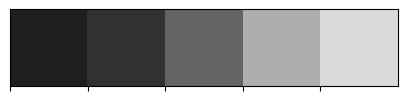

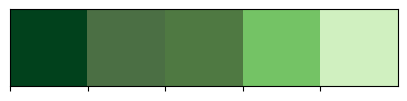

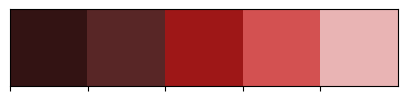

In [38]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

In [39]:
labels = ['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor', 'no_tumor']

In [40]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
# Initialize lists for storing data and labels
X_train = []
y_train = []

# Image size for resizing
image_size = 150

# Base paths for training and testing data in Google Drive
base_path_train = '/content/drive/My Drive/kaggle_tumor/Training'
base_path_test = '/content/drive/My Drive/kaggle_tumor/Testing'

# Load training data
for i in labels:
    folderPath = os.path.join(base_path_train, i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_train.append(img)
            y_train.append(i)

# Load testing data
X_test = []
y_test = []

for i in labels:
    folderPath = os.path.join(base_path_test, i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, j))
        if img is not None:
            img = cv2.resize(img, (image_size, image_size))
            X_test.append(img)
            y_test.append(i)

# Convert lists to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print("Training and testing data loaded successfully.")

100%|██████████| 105/105 [00:02<00:00, 47.91it/s]


Training and testing data loaded successfully.


In [42]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [43]:
X_train.shape

(2870, 150, 150, 3)

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [45]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [46]:
effnet = EfficientNetB0(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

16705208/16705208 [==============================] - 0s 0us/step


In [47]:
model = effnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=effnet.input, outputs = model)

In [48]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 150, 150, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 150, 150, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 150, 150, 3)          0         ['normalization[0][0]']   

In [49]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])

In [50]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("effnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

In [51]:
history = model.fit(X_train,y_train,validation_split=0.1, epochs =12, verbose=1, batch_size=32,
                   callbacks=[tensorboard,checkpoint,reduce_lr])

Epoch 1/12
73/73 [==============================] - ETA: 0s - loss: 0.4168 - accuracy: 0.8399
Epoch 1: val_accuracy improved from -inf to 0.86486, saving model to effnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


73/73 [==============================] - 368s 5s/step - loss: 0.4168 - accuracy: 0.8399 - val_loss: 0.6606 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 2/12
73/73 [==============================] - ETA: 0s - loss: 0.1494 - accuracy: 0.9497
Epoch 2: val_accuracy did not improve from 0.86486
73/73 [==============================] - 312s 4s/step - loss: 0.1494 - accuracy: 0.9497 - val_loss: 0.6948 - val_accuracy: 0.8031 - lr: 0.0010
Epoch 3/12
73/73 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9669
Epoch 3: val_accuracy did not improve from 0.86486

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
73/73 [==============================] - 309s 4s/step - loss: 0.1060 - accuracy: 0.9669 - val_loss: 0.7191 - val_accuracy: 0.8417 - lr: 0.0010
Epoch 4/12
73/73 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9867
Epoch 4: val_accuracy did not improve from 0.86486
73/73 [==============================] - 316s 4s/step - los

In [52]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

9/9 [==============================] - 12s 1s/step


In [53]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99        92
           1       0.93      0.97      0.95        71
           2       1.00      0.96      0.98        82
           3       0.95      1.00      0.98        42

    accuracy                           0.98       287
   macro avg       0.97      0.98      0.97       287
weighted avg       0.98      0.98      0.98       287



In [57]:
def img_pred(upload):
    for name, file_info in uploader.value.items():
        img = Image.open(io.BytesIO(file_info['content']))
    opencvImage = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
    img = cv2.resize(opencvImage,(150,150))
    img = img.reshape(1,150,150,3)
    p = model.predict(img)
    p = np.argmax(p,axis=1)[0]

    if p==0:
        p='Glioma Tumor'
    elif p==1:
        p='Meningioma Tumor'

    elif p==2:
        p='Pituitary Tumor'
    else:
        print('The model predicts that there is no tumor')

    if p!=1:
        print(f'The Model predicts that it is a {p}')

In [55]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [56]:
button = widgets.Button(description='Predict')
out = widgets.Output()
def on_button_clicked(_):
    with out:
        clear_output()
        try:
            img_pred(uploader)

        except:
            print('No Image Uploaded/Invalid Image File')
button.on_click(on_button_clicked)
widgets.VBox([button,out])